<a href="https://colab.research.google.com/github/Abhishekbhagwat/covid19_deeplearning_detection/blob/master/covid19detectionTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x
%matplotlib inline


import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
from skimage import exposure
from os import listdir

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import numpy as np
from skimage import exposure
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D


In [0]:
!gdown https://drive.google.com/uc?id=14M_KBXfjb8k6trqpU5iE0d_QkpZ4Rwki
!unzip covid_images.zip
!rm covid_images.zip

Downloading...
From: https://drive.google.com/uc?id=14M_KBXfjb8k6trqpU5iE0d_QkpZ4Rwki
To: /content/covid_images.zip
69.5MB [00:00, 113MB/s] 


In [0]:
data_list = listdir('/content/covid_images/images/train')

In [0]:
dataset_path  = '/content/covid_images/images/train'
test_dir =  '/content/covid_images/images/test'
image_size    = (150, 150)
num_classes   = len(data_list)
batch_size    = 10  
num_epochs    = 20
learning_rate =0.0005

In [0]:
# If you choose to use the standard classification metrics then you can add these metrics while compiling your model

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score


def precision(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    return precision


def recall(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    recall = c1 / c3

    return recall

In [0]:
#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

train_batches = train_datagen.flow_from_directory(dataset_path,
                                                  target_size=image_size,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="binary",
                                                  )

valid_batches = train_datagen.flow_from_directory(dataset_path,
                                                  target_size=image_size,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="binary",
                                                  )

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


In [0]:
from keras import optimizers
base_model = InceptionV3(weights='imagenet',include_top=False,input_shape=(150,150,3))
x = base_model.output

x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1,activation = 'sigmoid')(x)

# Creating model and compiling
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=optimizers.Adam(lr=learning_rate),loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [0]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_471 (Conv2D)             (None, 74, 74, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_476 (BatchN (None, 74, 74, 32)   96          conv2d_471[0][0]                 
__________________________________________________________________________________________________
activation_471 (Activation)     (None, 74, 74, 32)   0           batch_normalization_476[0][0]    
____________________________________________________________________________________________

In [0]:
# You can opt for an aggressive strategy to tune the learning rate as we are training for 15 epochs

train_step_size=train_batches.n//train_batches.batch_size
valid_step_size=valid_batches.n//valid_batches.batch_size

result=model.fit_generator(train_batches,
                        steps_per_epoch =train_step_size,
                        validation_data = valid_batches,
                        validation_steps = valid_step_size,
                        epochs= 15,
                       )

Epoch 1/15


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


10/10 [==============================] - 28s 3s/step - loss: 0.1081 - acc: 0.9598 - val_loss: 0.1887 - val_acc: 0.9000
Epoch 2/15
10/10 [==============================] - 29s 3s/step - loss: 0.1072 - acc: 0.9700 - val_loss: 0.1202 - val_acc: 0.9375
Epoch 3/15
10/10 [==============================] - 27s 3s/step - loss: 0.0597 - acc: 0.9799 - val_loss: 0.2699 - val_acc: 0.9375
Epoch 4/15
10/10 [==============================] - 27s 3s/step - loss: 0.4721 - acc: 0.9120 - val_loss: 0.3248 - val_acc: 0.8500
Epoch 5/15
10/10 [==============================] - 28s 3s/step - loss: 0.1292 - acc: 0.9397 - val_loss: 0.1510 - val_acc: 0.8750
Epoch 6/15
10/10 [==============================] - 29s 3s/step - loss: 0.0686 - acc: 0.9700 - val_loss: 1.6070 - val_acc: 0.7500
Epoch 7/15
10/10 [==============================] - 28s 3s/step - loss: 0.1705 - acc: 0.9361 - val_loss: 0.5137 - val_acc: 0.8000
Epoch 8/15
10/10 [==============================] - 27s 3s/step - loss: 0.1459 - acc: 0.9393 - val_lo

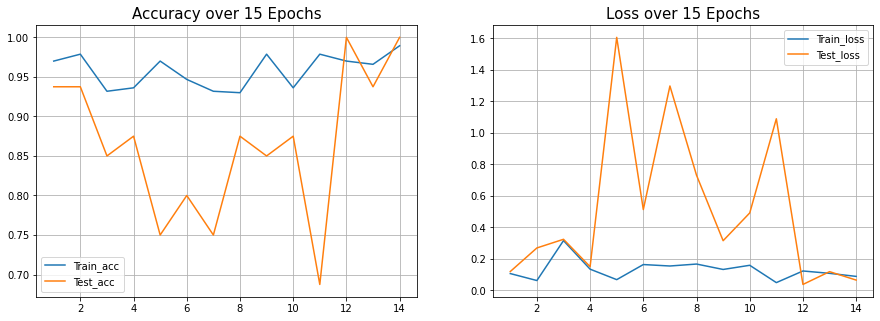

In [0]:
import matplotlib.pyplot as plt


def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, 15)

In [0]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=image_size,
        batch_size=1,
        shuffle=False,
        seed=42,
        class_mode="binary")

eval_generator.reset()

Found 18 images belonging to 2 classes.


In [0]:
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

18/18 [==============================] - 2s 112ms/step
Test loss: 0.10625744268449427
Test accuracy: 0.9444444444444444


In [0]:
eval_generator.reset()  
pred = model.predict_generator(eval_generator,1000,verbose=1)
print("Predictions finished")

1000/1000 [==============================] - 118s 118ms/step
Predictions finished


covid/nejmoa2001191_f3-PA.jpeg


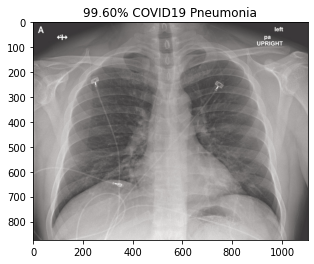

covid/nejmoa2001191_f4.jpeg


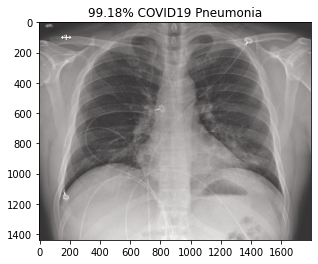

covid/nejmoa2001191_f5-PA.jpeg


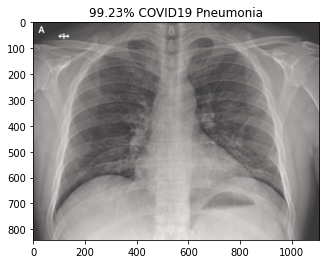

covid/radiol.2020200490.fig3.jpeg


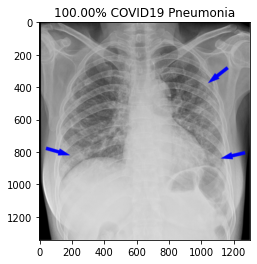

covid/ryct.2020200028.fig1a.jpeg


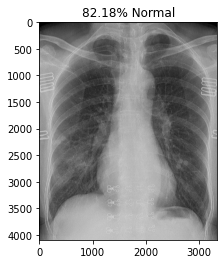

covid/ryct.2020200034.fig2.jpeg


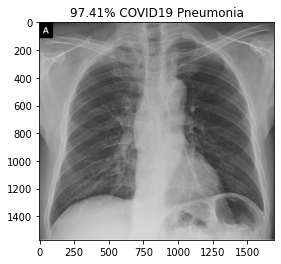

covid/ryct.2020200034.fig5-day0.jpeg


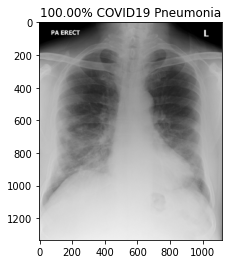

covid/ryct.2020200034.fig5-day4.jpeg


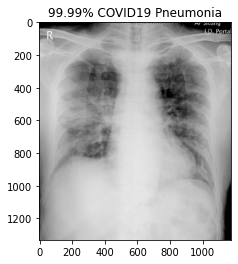

covid/ryct.2020200034.fig5-day7.jpeg


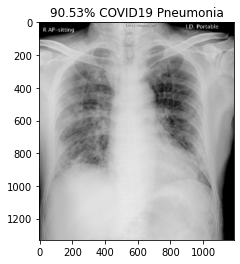

normal/NORMAL2-IM-1385-0001.jpeg


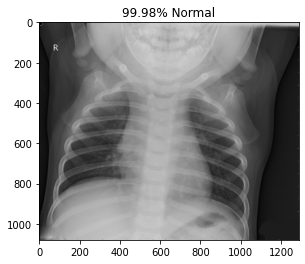

normal/NORMAL2-IM-1396-0001.jpeg


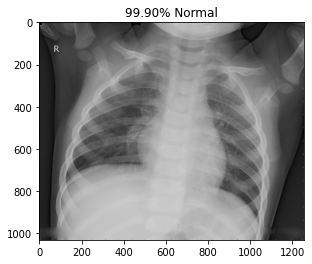

normal/NORMAL2-IM-1400-0001.jpeg


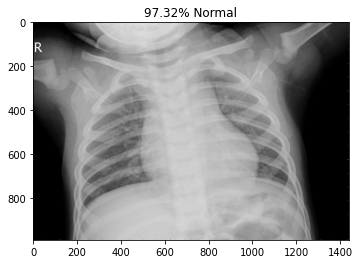

normal/NORMAL2-IM-1401-0001.jpeg


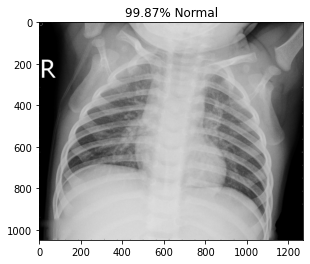

normal/NORMAL2-IM-1406-0001.jpeg


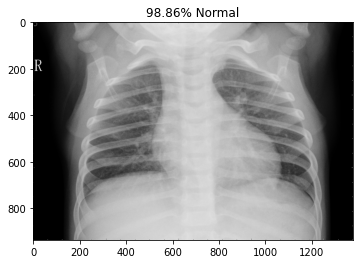

normal/NORMAL2-IM-1412-0001.jpeg


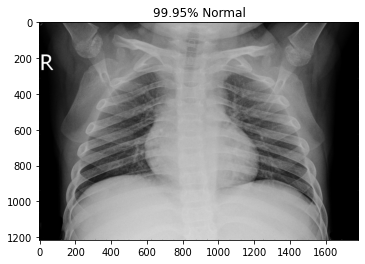

normal/NORMAL2-IM-1419-0001.jpeg


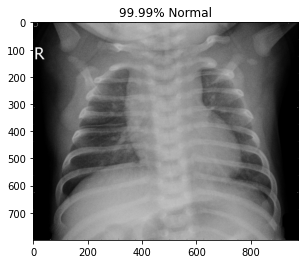

normal/NORMAL2-IM-1422-0001.jpeg


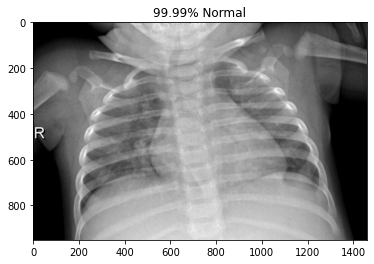

normal/NORMAL2-IM-1423-0001.jpeg


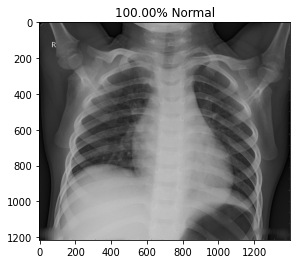

IndexError: ignored

In [0]:
import cv2


import matplotlib.image as mpimg
for index, probability in enumerate(pred):
    image_path = test_dir + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    #BGR TO RGB conversion using CV2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()